In [3]:
import pandas as pd

test = pd.read_csv("~/test.csv", index_col=0, sep=",")

In [4]:
test.head()

,mw_em_f,mw_file_directory,mw_file_hash,mw_file_size,mw_num_engines,pointerto_raw_data,section_name,virtual_size
21,0.025248175486922264;0.005167490337044001;0.00...,201703,00152DCC6083601EB5C3522862E6C922028C76733432DF...,_176488,1,146944,.MPRESS2,3201
43,0.048490963876247406;0.004562547896057367;0.00...,201703,04363646DEBF4D3A9B6B345FFF656909CE715DC602DD05...,_332928,0,1024,.text,7672
63,0.013231995515525341;0.004470598418265581;0.00...,201703,0CA44C40ACFA82B963297E1E7D437BE03005A1A330C7B5...,_328144,1,315392,.rsrc,8192
142,0.277099609375;0.0045219091698527345;0.0033542...,201703,05C5656937176784403E9286D275BD3804FC195BF33099...,_94208,1,4096,.text,8192
146,0.17463025450706482;0.02270572632551193;0.0099...,201703,0625975062030243058D8D45BEA4F95176B39B7AD3952E...,_21096,0,1024,.text,5362


In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plotRawWave(plotTitle, sampleRate, samples, figWidth=14, figHeight=4):
    plt.figure(figsize=(figWidth, figHeight))
    plt.plot(np.linspace(0, sampleRate/len(samples), sampleRate), samples)
    plt.title("Raw sound wave of " + plotTitle)
    plt.ylabel("Amplitude")
    plt.xlabel("Time [sec]")
    plt.show()  # force display while in for loop
    return None

In [47]:
X = np.zeros((test.shape[0], 10240), dtype=float)
# y = np.zeros(test.shape[0], dtype=float)
for i in range(test.shape[0]):
    base_path = "/ssd/2017/{0}/{1}{2}"
    item = test.iloc[i]

    file_path = base_path.format(item["mw_file_directory"], item["mw_file_hash"], item["mw_file_size"])
    in_file = open(file_path, 'rb')
    in_file.seek(item['pointerto_raw_data'])
    bytes_data = [int(single_byte) for single_byte in in_file.read(item['virtual_size'])]
    X[i, 0:len(bytes_data)] = bytes_data
#         y[i] = self.labels[ID]
#         plotRawWave("test", len(bytes_data), bytes_data, figWidth=14, figHeight=4)

In [90]:
base_path = "/ssd/2017/{0}/{1}{2}"
item = test.iloc[2]

file_path = base_path.format(item["mw_file_directory"], item["mw_file_hash"], item["mw_file_size"])
in_file = open(file_path, 'rb')
in_file.seek(item['pointerto_raw_data'])
bytes_data = [int(single_byte) for single_byte in in_file.read(item['virtual_size'])]
npa = np.asarray(bytes_data, dtype=float)

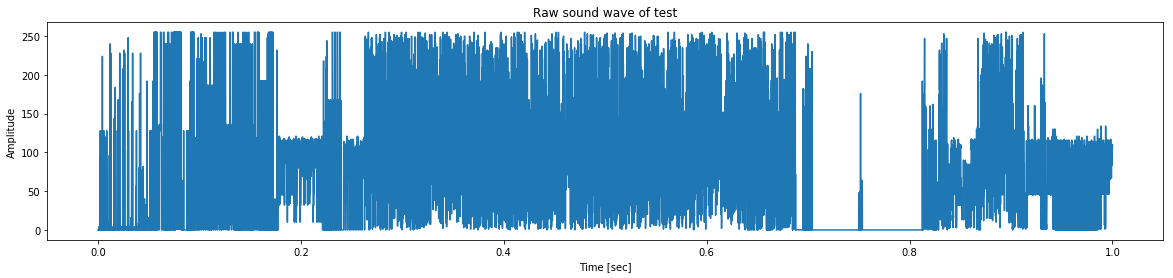

In [91]:
plotRawWave("test", len(npa), npa, figWidth=20, figHeight=4)

In [82]:
from scipy import signal

def plotLogSpectrogram(plotTitle, freqs, times, spectrogram, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
               cmap="inferno",   #  default was "viridis"  (perceptually uniform)
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.colorbar(pad=0.01)
    plt.title('Spectrogram of ' + plotTitle)
    plt.ylabel("Frequency [Hz]")
    plt.xlabel("Time [sec]")
    fig.tight_layout()
    plt.show()  # force display while in for loop
    return None

def computeLogSpectrogram(audio, sampleRate, windowSize=20, stepSize=10, epsilon=1e-10):
    nperseg  = int(round(windowSize * sampleRate / 1000))
    noverlap = int(round(stepSize   * sampleRate / 1000))
    freqs, times, spec = signal.spectrogram(audio,
                                            fs=sampleRate,
                                            window='hann',
                                            nperseg=nperseg,
                                            noverlap=noverlap,
                                            detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + epsilon)

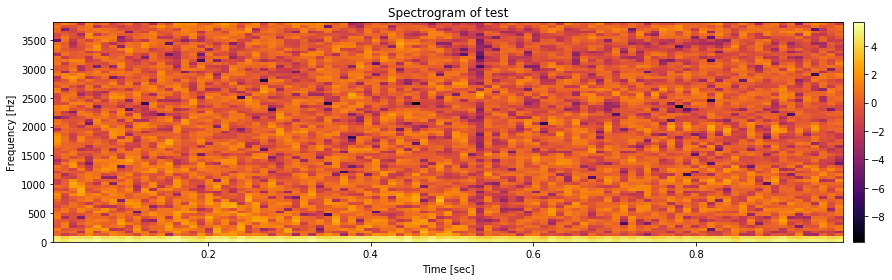

In [83]:
freqs, times, logSpectrogram = computeLogSpectrogram(npa, len(npa))
plotLogSpectrogram("test", freqs, times, logSpectrogram)

In [85]:
import librosa
import librosa.display

def computeLogMelSpectrogram(samples, sampleRate, nMels=128):
    melSpectrum = librosa.feature.melspectrogram(samples, sr=sampleRate, n_mels=nMels)
    
    # Convert to dB, which is a log scale.  Use peak power as reference.
    logMelSpectrogram = librosa.power_to_db(melSpectrum, ref=np.max)
    
    return logMelSpectrogram

def plotLogMelSpectrogram(plotTitle, sampleRate, logMelSpectrum, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(logMelSpectrum, sr=sampleRate, x_axis='time', y_axis='mel')
    plt.title('Mel log-frequency power spectrogram: ' + plotTitle)
    plt.colorbar(pad=0.01, format='%+02.0f dB')
    plt.tight_layout()  
    plt.show()  # force display while in for loop
    return None

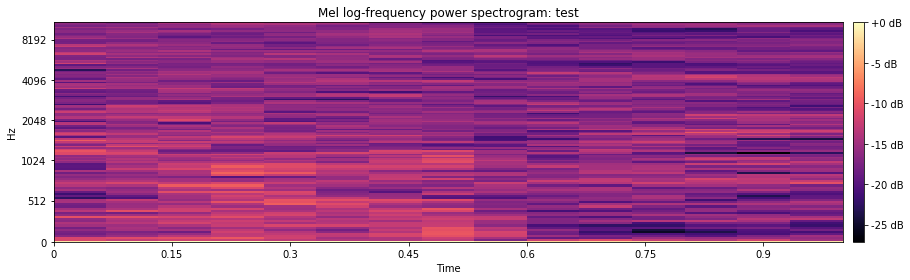

In [86]:
logMelSpectrogram = computeLogMelSpectrogram(npa, len(npa))
plotLogMelSpectrogram("test", len(npa), logMelSpectrogram)

In [87]:
def computeMFCC(samples, sampleRate, nFFT=512, hopLength=256, nMFCC=40):
    mfcc = librosa.feature.mfcc(y=samples, sr=sampleRate, 
                                n_fft=nFFT, hop_length=hopLength, n_mfcc=nMFCC)
    
    # Let's add on the first and second deltas  (what is this really doing?)
    #mfcc = librosa.feature.delta(mfcc, order=2)
    return mfcc

def plotMFCC(plotTitle, sampleRate, mfcc, figWidth=14, figHeight=4):
    fig = plt.figure(figsize=(figWidth, figHeight))
    librosa.display.specshow(mfcc, sr=sampleRate, x_axis='time', y_axis='mel')
    plt.colorbar(pad=0.01)
    plt.title("Mel-frequency cepstral coefficients (MFCC): " + plotTitle)
    plt.tight_layout()
    plt.show()  # force display while in for loop
    return None

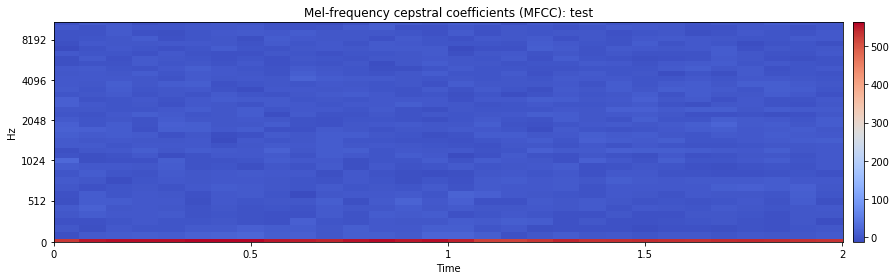

In [88]:
mfcc = computeMFCC(npa, len(npa))
#print(mfcc.shape)
plotMFCC("test", len(npa), mfcc)